In [1]:
# %pylab notebook
import numpy as np 
import h5py
import matplotlib.pyplot as plt

# %matplotlib ipympl

In [2]:
G3Xd = h5py.File('./data/G3X-profiles-progenitors_myevoz.hdf5','r')
GIZd = h5py.File('./data/GIZ-profiles-progenitors_myevoz.hdf5','r')

In [3]:
'''
calculate median profiles and percentile error [16,84] statistically

mod: simulation name [GIZMO or GadgetX]
d: simulation data
snap: which snapshot (equally redshift)
region: which property
ntclu: total cluster number (few clusters may not form at high redshift)
part: which particle part (default 0, this is not meaning DM particles)
'''

def cal_median(rbin, value, nbin):
    xmed = np.zeros(nbin)
    ymed = np.zeros(nbin)
    yerr = np.zeros(shape = (2,nbin))
    
    #calculate the median profile
    for j in range(nbin):
#         nonan = np.where((value[:,j]!= 0) & (np.isnan(value[:,j]) == False))[0]
        nonan = np.where((np.isnan(value[:,j]) == False))[0]
        if len(nonan) > 1:
            ymed[j] = np.median(value[nonan,j])
            xmed[j] = np.median(rbin[nonan,j])
            yerrtot = np.percentile(value[nonan,j],[16,84])
            yerr[0,j] = yerrtot[0]
            yerr[1,j] = yerrtot[1]
    return xmed,ymed,yerr

def cal_sta_profiles(mod,d,snap,region,bin25,ntclu,part = 0):
    nbin = 50
    allvalue=np.zeros(shape = (ntclu,nbin))
    rbinvalue=np.zeros(shape = (ntclu,nbin))
    npvalue=np.zeros(shape = (ntclu,nbin))
    allm500 = np.zeros(ntclu)
    
    redshift = d['NewMDCLUSTER_0001/snap_%03d'%(snap)].attrs['redshift']
    
    i = 0
    #read raw data
    for nclu in range(324):
        if 'Rbin' not in d['NewMDCLUSTER_0%03d/snap_%03d'%(nclu+1, snap)]:          
            continue
        r500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r500']
        allvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][:]
        rbinvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/Rbin'%(nclu+1,snap)][:] / r500 #unit: r/r500
        allm500[i] = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['M500']
        npvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/NuminBin'%(nclu+1,snap)][0]

        i+=1
    print(i)
            
    if bin25 == True:
        # combine nearby bins with near 2
        rbin25 = np.zeros(shape = (ntclu, 25))
        value25 = np.zeros(shape = (ntclu, 25))
        np25 = np.zeros(shape = (ntclu, 25))
        for i in range(ntclu):
            for j in range(25):
                bin0 = j*2
                bin1 = j*2+1
                value25[i,j] = (allvalue[i,bin0] + allvalue[i,bin1]) / 2
                rbin25[i,j] = (rbinvalue[i,bin0] + rbinvalue[i,bin1]) / 2
                np25[i,j] = npvalue[i,bin0] + npvalue[i,bin1]
        
        np_med = np.median(np25, axis = 0)
        np25 = np.sum(np25, axis = 1)
        idnp = np.where(np25 >= 50)[0]
        print('input sample is', idnp.shape[0])
        xmed,ymed,yerr = cal_median(rbin25[idnp], value25[idnp], 25)
        return xmed,ymed,yerr,np_med
    else:       
        np_med = np.median(npvalue, axis = 0)
        npvalue = np.sum(npvalue, axis = 1)
        idnp = np.where(npvalue >= 50)[0]
        print('input sample is', idnp.shape[0])
        xmed,ymed,yerr = cal_median(rbinvalue[idnp], allvalue[idnp], 50)
        return xmed,ymed,yerr,np_med

In [4]:
def ob_Metallicity(ax):
    #Lovisari+2019
    Lov = './data/ob_Metallicity/Lovisari+2019.csv'
    dataM = np.loadtxt(open(Lov, 'r'),delimiter = ',')
    
    sizeM = dataM.shape
    Mn = int(sizeM[0]/5)
    data1 = np.zeros(Mn)
    data2 = np.zeros(Mn)
    data3 = np.zeros(shape = (Mn,2))
    data4 = np.zeros(Mn)
    data5 = np.zeros(Mn)

    i = 0
    j = 0
    while i < sizeM[0]:
        datavol = np.sort(dataM[i+1:i+4], axis = 0)
        data3[j][0] = datavol[1][0]
        data3[j][1] = datavol[1][1]

        data1[j] = data3[j][0] - dataM[i][0]
        data2[j] = datavol[0][1] - data3[j][1]
        data4[j] = data3[j][1] - datavol[2][1]
        data5[j] = dataM[i+4][0] - data3[j][0]
        i += 5
        j += 1
    
#     plt.fill_between(data3[:,0],data3[:,1] - data4, data3[:,1] + data2, color = 'cyan', alpha = 0.3)
#     plt.plot(data3[:,0], data3[:,1], color = 'cyan', marker = 's', label = 'Lovisari + 2019', zorder = 100)
    ax.errorbar(data3[:,0], data3[:,1], yerr = [data4,data2], xerr = [data1,data5], zorder = 0, alpha = 1,
                 mfc = 'none', capsize = 2, ms = 5, fmt = 'o',c = 'grey', label = 'Lovisari+2019 (z<0.1)')
    
    #-------------------------------------------
    #Baldi+2012 (Zsun = 0.01886 from A&G+1989)
    z4_5=np.array([0.32,0.25,0.17]) * 0.01886 / 0.0134
    z4_5err= np.array([0.02,0.03,0.04])* 0.01886 / 0.0134
    z5_7=np.array([0.37,0.27,0.15])* 0.01886 / 0.0134
    z5_7err= np.array([0.03,0.03,0.04])* 0.01886 / 0.0134
    z7_14=np.array([0.28,0.19,0.09])* 0.01886 / 0.0134
    z7_14err= np.array([0.09,0.05,0.08])* 0.01886 / 0.0134
    xrange = np.array([0,0.15,0.4,1])
    
    for i in range(3):
        xx = np.linspace(xrange[i],xrange[i+1],100)
        if i == 0:
            sc = ax.fill_between(xx,z4_5[i] - z4_5err[i], z4_5[i] + z4_5err[i], label = 'Baldi+2012 (0.4<z<0.5)',
                         color = 'grey', alpha = 0.5, zorder = -1)
        else:
            sc = ax.fill_between(xx,z4_5[i] - z4_5err[i], z4_5[i] + z4_5err[i],
                         color = 'grey', alpha = 0.5, zorder = -1)

    for i in range(3):
        xx = np.linspace(xrange[i],xrange[i+1],100)
        if i == 0:
            sc = ax.fill_between(xx,z5_7[i] - z5_7err[i], z5_7[i] + z5_7err[i], label = 'Baldi+2012 (0.5<z<0.7)',
                         hatch = '////',color = 'grey', fc = 'none',alpha = 0.6, zorder = -1)
            sc.set_facecolor('none')
        else:
            sc = ax.fill_between(xx,z5_7[i] - z5_7err[i], z5_7[i] + z5_7err[i],
                         hatch = '////',color = 'grey', fc = 'none',alpha = 0.6, zorder = -1)
            sc.set_facecolor('none')
            
    for i in range(3):
        xx = np.linspace(xrange[i],xrange[i+1],100)
        if i == 0:
            sc = ax.fill_between(xx,z7_14[i] - z7_14err[i], z7_14[i] + z7_14err[i], label = 'Baldi+2012 (0.7<z<1.4)',
                         hatch = '\\\\',color = 'grey', fc = 'none',alpha = 0.5, zorder = -1)
            sc.set_facecolor('none')
        else:
            sc = ax.fill_between(xx,z7_14[i] - z7_14err[i], z7_14[i] + z7_14err[i],
                         hatch = '\\\\',color = 'grey', fc = 'none',alpha = 0.5, zorder = -1)
            sc.set_facecolor('none')
    #----------------------------------------------
#     #Ettori+2015
#     mdata=np.array([0.647,0.271,0.173]) * 0.01886 / 0.0134
#     merrup= np.array([0.082,0.035,0.068])* 0.01886 / 0.0134
#     merrlow = np.array([0.073,0.042,0.044])* 0.01886 / 0.0134
#     xrange = np.array([0,0.15,0.4,1])
#     xx = np.array([0.15/2,0.55/2,1.4/2])
#     ax.errorbar(xx, mdata, yerr = [merrlow, merrup], xerr = [xx - xrange[:3], xrange[1:] - xx],
#                 fmt = '.', capsize = 2, c = 'orange', label = 'Ettori+2015 (0.09 < z < 1.39)',lw = 2, alpha =0.5, zorder = 200)




324
input sample is 324
324
input sample is 324
324
input sample is 324
324
input sample is 324
324
input sample is 324
324
input sample is 324
323
input sample is 323
324
input sample is 324
323
input sample is 323
323
input sample is 323


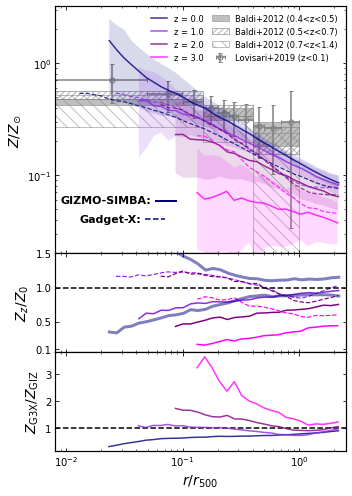

In [5]:
#Combined results
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (5,7))
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.2 #set the value globally
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((9,4),(0,0),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((9,4),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((9,4),(7,0),colspan = 4,rowspan = 2)


snapb = [128,96,78,65,55,47,40]
redb = ['z = 0.0','z = 1.0','z = 2.0','z = 3.0','z = 4.0']
# colall = ['b','r','k','orange','cyan','magenta','green']
colall = ['navy','blueviolet','purple','magenta','r']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]
idtGIZ = [37,31,26,21,9,7,7]
idtG3X = [37,33,27,21,8,8,9]
#==========================================================
# GIZMO
for i in [0,1,2,3]:
    if i == 0:
        xmed0,ymed0,yerr0,np_med0 = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWMetal',False,nGIZ[i])
        xmed25,ymed25,yerr25,np_med25 = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWMetal',True,nGIZ[i])
        idt = np.where(np_med0 >= 10)[0]
        ax1.plot(xmed0[idt],ymed0[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha=0.8)
        ax1.fill_between(xmed0[idt],yerr0[0,idt],yerr0[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed0[idt],yerr0[0,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        ax10.plot(xmed0[idt],yerr0[1,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        
        xmed0_x,ymed0_x,yerr0_x,np_med0_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWMetal',False,nG3X[i])
        xmed25_x,ymed25_x,yerr25_x,np_med25_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWMetal',True,nG3X[i])
        idt_x = np.where(np_med0_x >= 10)[0]
        ax1.plot(xmed0_x[idt_x],ymed0_x[idt_x],lw = 1.2, ls = '--',  c=colall[i], zorder = 30,alpha = 0.8)
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed0_x[idt_x],ymed0_x[idt_x]/ymed0[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed0_x[idt],ymed0_x[idt]/ymed0[idt], c=colall[i], zorder = 30,alpha = 0.8)
        
    elif i <= 3:
        xmed,ymed,yerr,np_med = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWMetal',False,nGIZ[i])
        idt = np.where(np_med >= 10)[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed0[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x,np_med_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWMetal',False,nG3X[i])
        idt_x = np.where(np_med_x >= 10)[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x], ymed_x[idt_x]/ymed0_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed_x[idt],ymed_x[idt]/ymed[idt], c=colall[i], zorder = 30,alpha = 0.8)
        
    else:
        xmed,ymed,yerr,np_med = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWMetal',True,nGIZ[i])
        idt = np.where(np_med >= 10)[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color =colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed25[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x,np_med_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWMetal',True,nG3X[i])
        idt_x = np.where(np_med_x >= 10)[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed25_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed_x[idt],ymed_x[idt]/ymed[idt], c=colall[i], zorder = 30,alpha = 0.8)
    
     
    
ax1.text(0.009,5.58e-2,'GIZMO-SIMBA:',weight = 'bold',size = 11) 
ax1.text(0.013,3.8e-2,'Gadget-X:',weight = 'bold',size = 11) 

from matplotlib.lines import Line2D
lin1 = Line2D([],[],c = 'navy',lw = 2)
legend2 = ax1.legend(handles=[lin1],frameon = False, loc = (0.335,0.175))
ax1.add_artist(legend2)

lin0 = Line2D([],[],c = 'navy',lw = 1.5, ls = '--')
legend0 = ax1.legend(handles=[lin0],frameon = False, loc = (0.295,0.10))
ax1.add_artist(legend0)

ob_Metallicity(ax1)
ax1.legend(fontsize = 'small',ncol = 2, loc = 1, frameon = False, columnspacing = 1)
#==========================================================================
# ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='k',ls='--')

ax1.set_ylabel(r'$Z/Z_{\odot}$', fontsize = 14)
ax1.loglog()
# ax1.set_xscale('log')

ax1.axes.xaxis.set_ticklabels([])
ax1.set_ylim(2e-2,3.2)
ax1.set_xlim(0.008,2.5)
# ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(0.008,2.5)
ax10.set_ylim(0.05,1.5)
ax10.set_yticks([0.1,0.5,1,1.5])
# ax10.axes.yaxis.set_ticks([0.03,1,2])
ax10.set_xlabel(r'$r/r_{500}$',fontsize = 14)
ax10.set_ylabel(r'$Z_z/Z_0$',fontsize = 14)

ax20.axhline(1,c='k',ls='--')
ax20.set_xscale('log')
ax20.set_xlim(0.008,2.5)
# ax20.set_ylim(0.4,2.8)
ax20.set_xlabel(r'$r/r_{500}$', fontsize = 14)
ax20.set_ylabel(r'$Z_{\rm G3X}/Z_{\rm GIZ}$', fontsize = 14)
ax20.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)

ax1.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
ax10.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
plt.tight_layout()
plt.subplots_adjust(wspace =0 ,hspace = 0)
plt.savefig('./figsv2/Metallicity.pdf')

In [5]:
#study evolution of temperature
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (9.5,5))
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((7,8),(0,0),colspan = 4,rowspan = 5)
ax2 = plt.subplot2grid((7,8),(0,4),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((7,8),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((7,8),(5,4),colspan = 4,rowspan = 2)

snapb = [128,95,78,65,55,47,40]
redb = ['z = 0','z = 1.076','z = 2.021','z = 3.027','z = 4.018','z = 5.0','z = 6.0']
colall = ['b','r','k','orange','cyan','magenta','g']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]

for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWMetal',nGIZ[i])
        ax1.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'MWMetal',nGIZ[i])
        ax1.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax10.plot(xmed0,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='grey',ls='--')

ax1.text(0.6,1.5,'GIZMO',weight = 'bold',size = 11)
ax1.set_ylabel(r'$Z/Z_{\odot}$')
ax1.loglog()
ax1.legend(fontsize = 'x-small', loc = 3)
ax1.axes.xaxis.set_ticklabels([])
ax1.set_ylim(1e-2,3)
ax1.set_xlim(0.008,3)
ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(0.008,3)
ax10.set_ylim(0.05,1.7)
ax10.set_yticks([0.5,1,1.5])
# ax10.axes.yaxis.set_ticks([0.03,1,2])
ax10.set_xlabel(r'$r/r_{500}$')
ax10.set_ylabel(r'$Z_z/Z_0$')

#Gadget-X
for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWMetal',nG3X[i])
        ax2.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'MWMetal',nG3X[i])
        ax2.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax20.plot(xmed0,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax20.grid(c = 'grey', ls = '--', alpha = 0.5)
ax20.axhline(1,c='grey',ls='--')
ax2.text(0.5,1.5,'Gadget-X',weight = 'bold',size = 11)

ax2.grid(c = 'grey', ls = '--', alpha = 0.5)
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])
ax2.set_ylim(1e-2,3)
ax2.set_xlim(0.008,3)
ax2.loglog()
ax2.set_yticks([1,0.1])
ax2.set_yticklabels( labels = [])

ax20.set_xscale('log')
ax20.set_xlim(0.008,3)
ax20.set_ylim(0.05,1.7)
ax20.set_xlabel(r'$r/r_{500}$')
ax20.set_yticks([0.5,1,1.5])
ax20.set_yticklabels([])

# plt.savefig('./figs/Gdens.pdf')
# plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


318


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


306


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


320


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


305


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(0, 0.5, ''), Text(0, 1.0, ''), Text(0, 1.5, '')]

In [3]:
def ob_Metallicity():
    #Lovisari+2019
    Lov = './data/ob_Metallicity/Lovisari+2019.csv'
    dataM = np.loadtxt(open(Lov, 'r'),delimiter = ',')
    
    sizeM = dataM.shape
    Mn = int(sizeM[0]/5)
    data1 = np.zeros(Mn)
    data2 = np.zeros(Mn)
    data3 = np.zeros(shape = (Mn,2))
    data4 = np.zeros(Mn)
    data5 = np.zeros(Mn)

    i = 0
    j = 0
    while i < sizeM[0]:
        datavol = np.sort(dataM[i+1:i+4], axis = 0)
        data3[j][0] = datavol[1][0]
        data3[j][1] = datavol[1][1]

        data1[j] = data3[j][0] - dataM[i][0]
        data2[j] = datavol[0][1] - data3[j][1]
        data4[j] = data3[j][1] - datavol[2][1]
        data5[j] = dataM[i+4][0] - data3[j][0]
        i += 5
        j += 1
    
#     plt.fill_between(data3[:,0],data3[:,1] - data4, data3[:,1] + data2, color = 'cyan', alpha = 0.3)
#     plt.plot(data3[:,0], data3[:,1], color = 'cyan', marker = 's', label = 'Lovisari + 2019', zorder = 100)
    plt.errorbar(data3[:,0], data3[:,1], yerr = [data4,data2], xerr = [data1,data5], zorder = 105,
                 mfc = 'none', capsize = 2, ms = 5, fmt = 'o',c = 'cyan', label = 'Lovisari+2019 (z<0.1)')
    
    #-------------------------------------------
    #Baldi+2012 (Zsun = 0.01886 from A&G+1989)
    z4_5=np.array([0.32,0.25,0.17]) * 0.01886 / 0.0134
    z4_5err= np.array([0.02,0.03,0.04])* 0.01886 / 0.0134
    z5_7=np.array([0.37,0.27,0.15])* 0.01886 / 0.0134
    z5_7err= np.array([0.03,0.03,0.04])* 0.01886 / 0.0134
    z7_14=np.array([0.28,0.19,0.09])* 0.01886 / 0.0134
    z7_14err= np.array([0.09,0.05,0.08])* 0.01886 / 0.0134
    xrange = np.array([0,0.15,0.4,1])
    
    for i in range(3):
        xx = np.linspace(xrange[i],xrange[i+1],100)
        if i == 0:
            sc = plt.fill_between(xx,z4_5[i] - z4_5err[i], z4_5[i] + z4_5err[i], label = 'Baldi+2012 (0.4<z<0.5)',
                         hatch = '//',color = 'b', fc = 'none',alpha = 0.8, zorder = 100)
            sc.set_facecolor('none')
        else:
            sc = plt.fill_between(xx,z4_5[i] - z4_5err[i], z4_5[i] + z4_5err[i],
                         hatch = '//',color = 'b', fc = 'none',alpha = 0.8, zorder = 100)
            sc.set_facecolor('none')

    for i in range(3):
        xx = np.linspace(xrange[i],xrange[i+1],100)
        if i == 0:
            sc = plt.fill_between(xx,z5_7[i] - z5_7err[i], z5_7[i] + z5_7err[i], label = 'Baldi+2012 (0.5<z<0.7)',
                         hatch = '//',color = 'r', fc = 'none',alpha = 0.8, zorder = 100)
            sc.set_facecolor('none')
        else:
            sc = plt.fill_between(xx,z5_7[i] - z5_7err[i], z5_7[i] + z5_7err[i],
                         hatch = '\\',color = 'r', fc = 'none',alpha = 0.8, zorder = 100)
            sc.set_facecolor('none')
            
    for i in range(3):
        xx = np.linspace(xrange[i],xrange[i+1],100)
        if i == 0:
            sc = plt.fill_between(xx,z7_14[i] - z7_14err[i], z7_14[i] + z7_14err[i], label = 'Baldi+2012 (0.7<z<0.1.4)',
                         hatch = '||',color = 'k', fc = 'none',alpha = 0.8, zorder = 100)
            sc.set_facecolor('none')
        else:
            sc = plt.fill_between(xx,z7_14[i] - z7_14err[i], z7_14[i] + z7_14err[i],
                         hatch = '||',color = 'k', fc = 'none',alpha = 0.8, zorder = 100)
            sc.set_facecolor('none')
    #----------------------------------------------
    #Ettori+2015
    mdata=np.array([0.647,0.271,0.173]) * 0.01886 / 0.0134
    merrup= np.array([0.082,0.035,0.068])* 0.01886 / 0.0134
    merrlow = np.array([0.073,0.042,0.044])* 0.01886 / 0.0134
    xrange = np.array([0,0.15,0.4,1])
    xx = np.array([0.15/2,0.55/2,1.4/2])
    plt.errorbar(xx, mdata, yerr = [merrlow, merrup], xerr = [xx - xrange[:3], xrange[1:] - xx],
                fmt = '.', capsize = 2, c = 'orange', label = 'Ettori+2015 (0.09 < z < 1.39)',lw = 2, zorder = 200)

plt.figure()
ob_Metallicity()
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$Z/Z_{\odot}$')
plt.loglog()
plt.xlim(1e-2,2.5)
plt.ylim(4e-2,3)
plt.legend()
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<IPython.core.display.Javascript object>


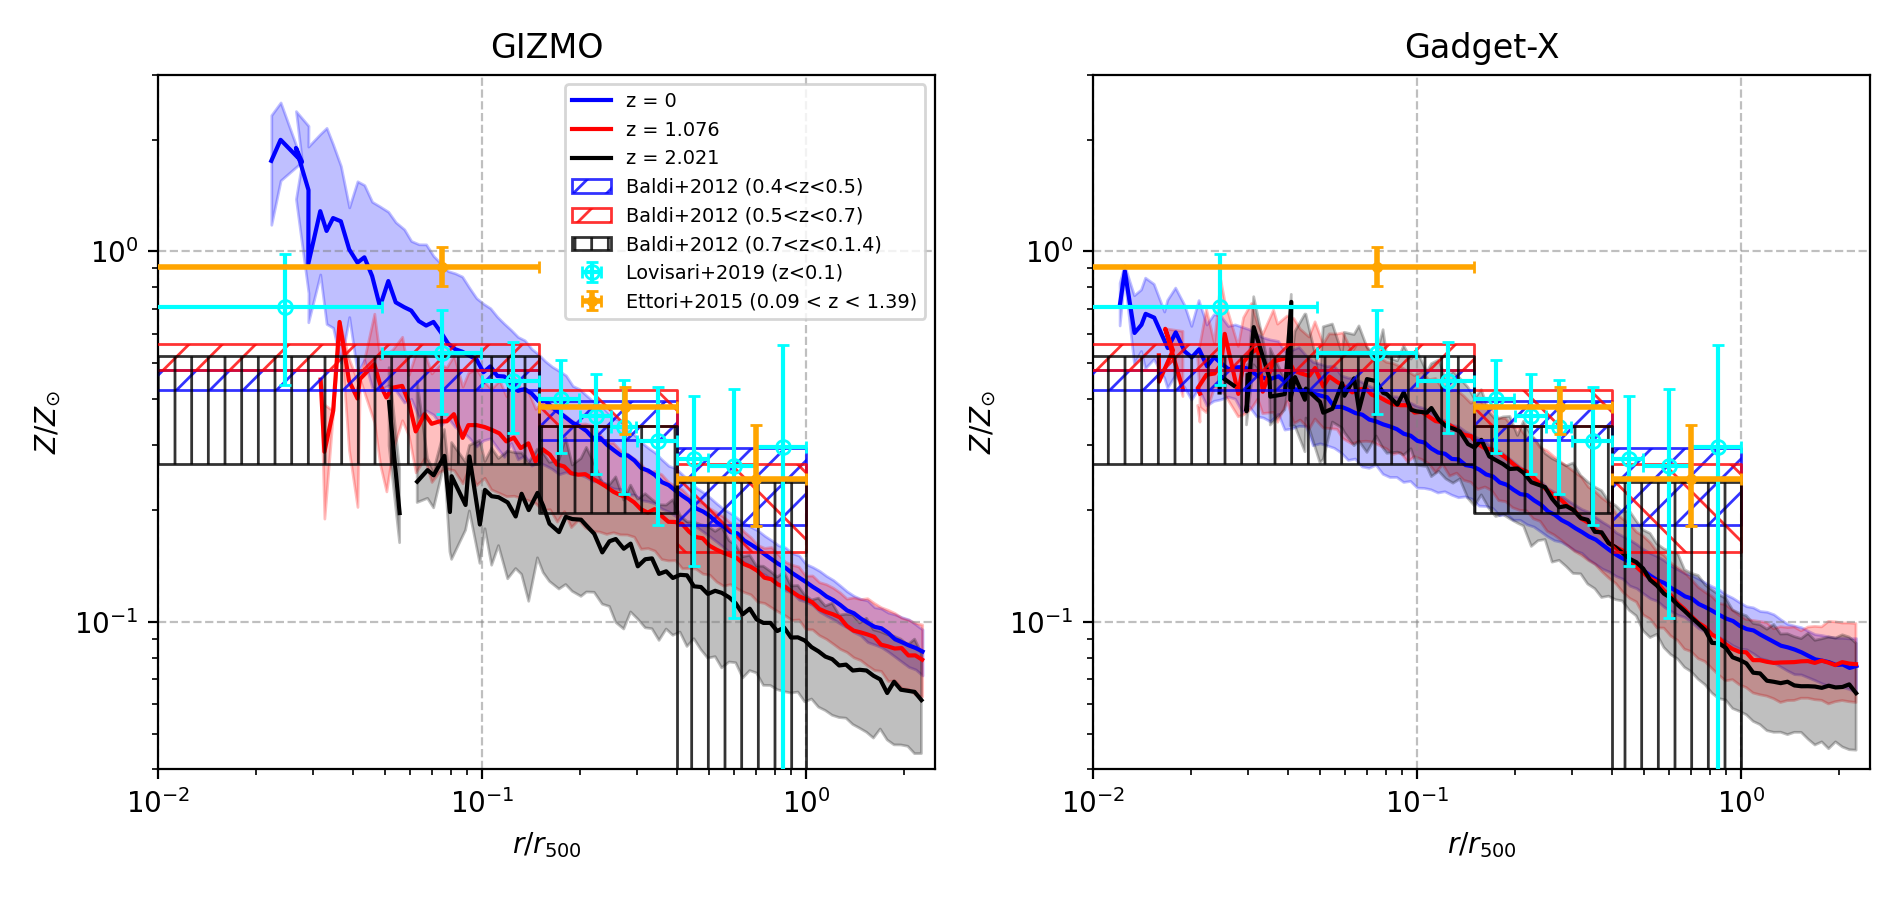

324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [95]:
#mass-weighted metallicity

plt.figure(figsize = (9.5,4.5))

plt.subplot(121)
#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'MWMetal',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)
#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'MWMetal',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)
#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'MWMetal',323)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

ob_Metallicity()

plt.title('GIZMO')
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$Z/Z_{\odot}$')
plt.legend(fontsize = 'x-small')
plt.loglog()
plt.xlim(1e-2,2.5)
plt.ylim(4e-2,3)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

plt.subplot(122)
#z = 0
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,128,'MWMetal',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)
#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,95,'MWMetal',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)
#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,78,'MWMetal',324)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

ob_Metallicity()

plt.title('Gadget-X')
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$Z/Z_{\odot}$')
plt.loglog()
plt.xlim(1e-2,2.5)
plt.ylim(4e-2,3)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

plt.tight_layout()

<IPython.core.display.Javascript object>


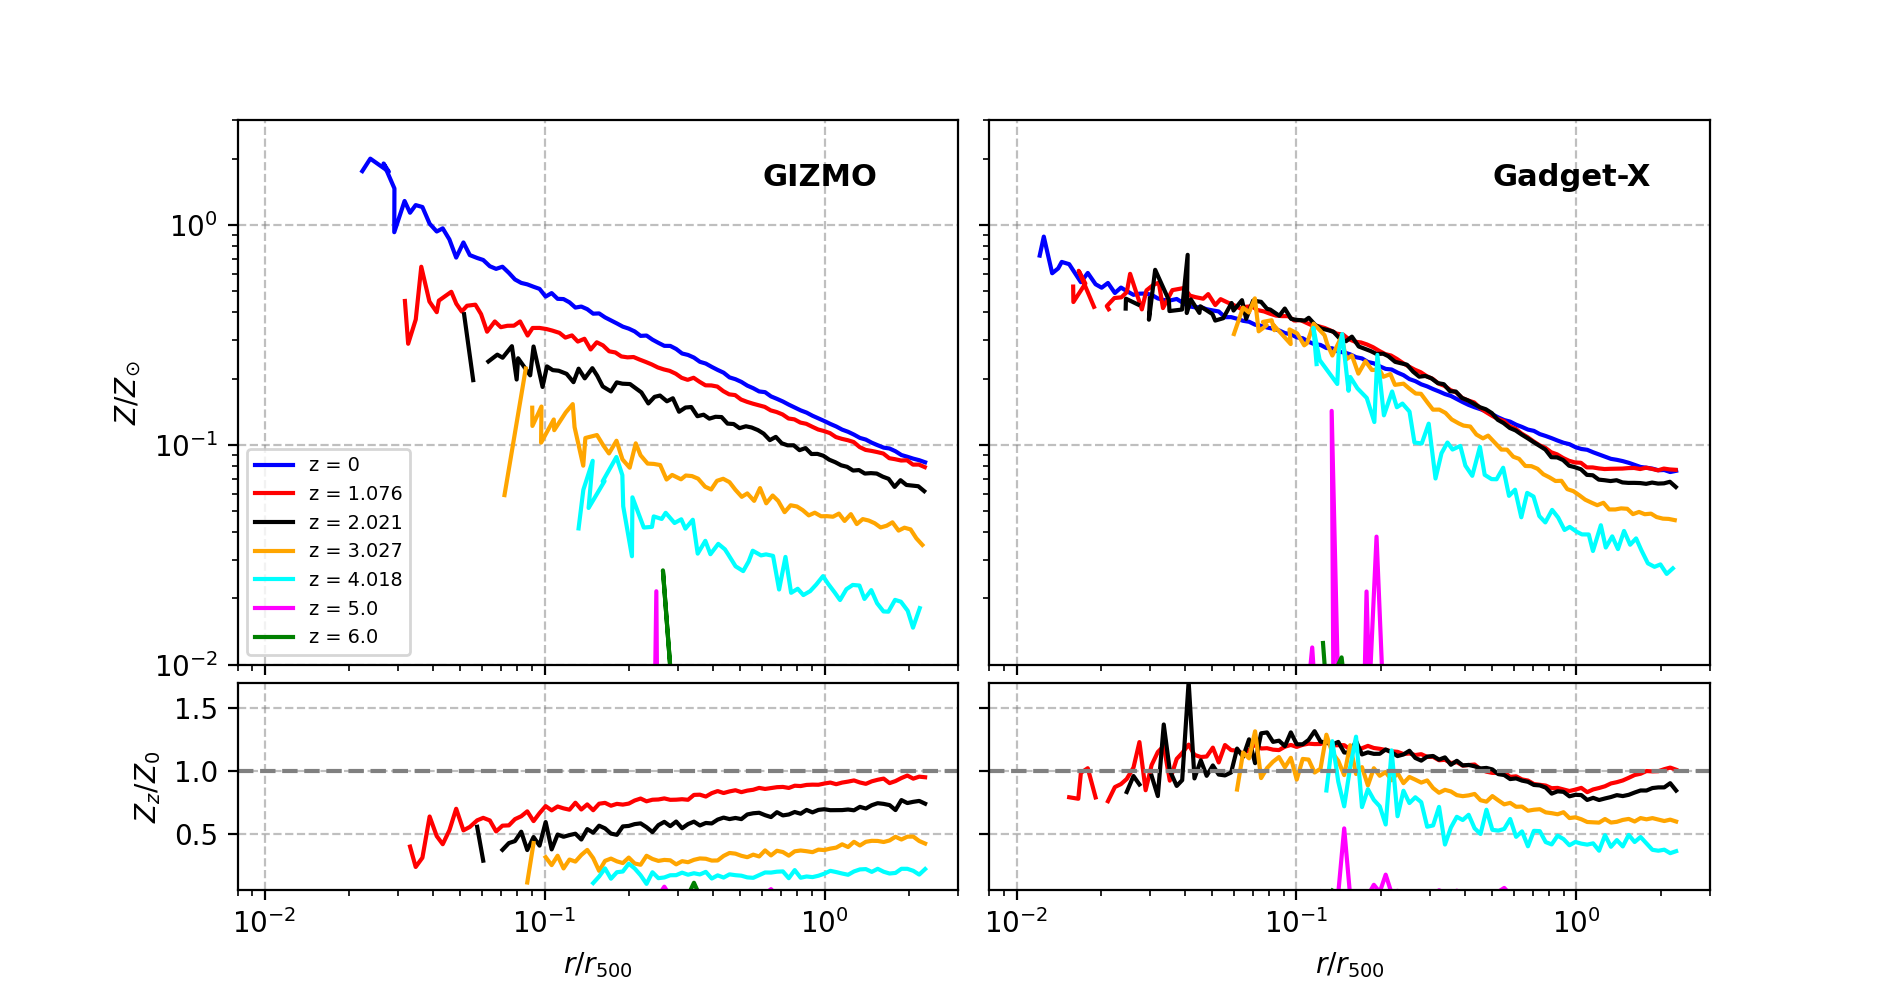

324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


318


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


306


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


320


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


305


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
